# Recency, Frequency, and Monetary Value Analysis of Customer Purchases

This notebook provides a template for performing Recency, Frequency, and Monetary Value (RFM) analysis based on customer purchases (orders, transactions, etc.).

### Use Case
We assume a historical dataset where each record represents a purchase (order, transaction, etc.). Each purchase is associated with a customer ID, timestamp, monetary value, and, optionally, other qualifiers such as customer location. We want to compute the following metrics for each customer:
* `T` - time since the first purchase (customer age) 
* `recency` - time since the last purchase
* `frequency` - total number of purchases
* `monetary_value` - total of all past purchases

We also want to analyze customer cohorts spanned on these metrics and answer questions like "What recency and frequency cohorts are the most important for our business?" and "How RFM metrics differ across the locations?"

### Prototype: Approach and Data
Our implementation of the RFM calculation procedure is based on [1]. We test it using the UCI Online Retail dataset (see `datasets.md` for details).

### Usage and Productization
The RFM calculation procedure is scalable and can be used to create production-grade solutions. 

### References
1. PyMC Marketing https://github.com/pymc-labs/pymc-marketing
2. https://github.com/takechanman1228/Effective-CLV-Modeling

In [1]:
#
# Imports
#
import zipfile
import os

import numpy as np
import pandas as pd
from typing import Optional

import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Cleansing

In this section, we load the UCI Online Retail dataset (see `datasets.md` for details) and pre-process it to adjust for cancellations and exclude incomplete records.

In [2]:
filename = "online_retail.zip"

# Unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("online_retail_data")

# Finding the Excel file name
excel_file = None
for file in os.listdir("online_retail_data"):
    if file.endswith(".xlsx"):
        excel_file = os.path.join("online_retail_data", file)

# Convert from Excel to CSV
data_raw = pd.read_excel(excel_file)

In [4]:
#
# Removing return orders (where InvoiceNo starts with "C")
#
cancelled_orders = data_raw[data_raw['InvoiceNo'].astype(str).str.startswith("C")].copy()
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']
merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']], 
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'], 
                       how='left', indicator=True)
data_filtered = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['InvoiceNo'].astype(str).str.startswith("C"))]
data_filtered = data_filtered.drop(columns=['_merge'])

#
# Selecting relevant features and calculating total sales
#
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_filtered[features].copy()
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

#
# Removing transactions with missing customer IDs as they don't contribute to individual customer behavior
#
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
data.head()

,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,17850,536365,2010-12-01 08:26:00,6,2.55,United Kingdom,15.30
1,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
2,17850,536365,2010-12-01 08:26:00,8,2.75,United Kingdom,22.00
3,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
4,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34


## Compute Recency-Frequency-Monetary Metrics

In this section, we implement the RFM calculation procedure and run it for the test dataset.

In [6]:
def _find_first_transactions(
    transactions: pd.DataFrame,
    customer_id_col: str,
    datetime_col: str,
    monetary_value_col: str,
    datetime_format: Optional[str] = None,
    time_unit: str = "D"
) -> pd.DataFrame:
    select_columns = [customer_id_col, datetime_col, monetary_value_col]

    transactions = transactions[select_columns].sort_values(select_columns).copy()

    # convert date column into a DateTimeIndex for time-wise grouping and truncating
    transactions[datetime_col] = pd.to_datetime(
        transactions[datetime_col], format=datetime_format
    )
    transactions = (
        transactions.set_index(datetime_col).to_period(time_unit).to_timestamp()
    )
    transactions = transactions.reset_index()

    period_groupby = transactions.groupby(
        [datetime_col, customer_id_col], sort=False, as_index=False
    )

    period_transactions = period_groupby.sum()

    # create a new column for flagging first transactions
    period_transactions = period_transactions.copy()
    period_transactions.loc[:, "first"] = False
    # find all first transactions and store as an index
    first_transactions = (
        period_transactions.groupby(customer_id_col, sort=True, as_index=False)
        .head(1)
        .index
    )
    # flag first transactions as True
    period_transactions.loc[first_transactions, "first"] = True
    select_columns.append("first")
    # reset datetime_col to period
    period_transactions.loc[:, datetime_col] = period_transactions[
        datetime_col
    ].dt.to_period(time_unit)

    return period_transactions[select_columns] 

def rfm_summary(
    transactions: pd.DataFrame,
    customer_id_col: str,
    datetime_col: str,
    monetary_value_col: str,
    datetime_format: Optional[str] = None,
    time_unit: str = "D",
    include_first_transaction: Optional[bool] = False,
) -> pd.DataFrame:

    observation_period_end_ts = (
            pd.to_datetime(transactions[datetime_col].max(), format=datetime_format)
            .to_period(time_unit)
            .to_timestamp()
    )

    # label repeated transactions
    repeated_transactions = _find_first_transactions(  # type: ignore
        transactions,
        customer_id_col,
        datetime_col,
        monetary_value_col,
        datetime_format,
        time_unit,
    )
    # reset datetime_col to timestamp
    repeated_transactions[datetime_col] = repeated_transactions[
        datetime_col
    ].dt.to_timestamp()

    # count all orders by customer
    customers = repeated_transactions.groupby(customer_id_col, sort=False)[
        datetime_col
    ].agg(["min", "max", "count"])

    if not include_first_transaction:
        # subtract 1 from count, as we ignore their first order.
        customers["frequency"] = customers["count"] - 1
    else:
        customers["frequency"] = customers["count"]

    customers["T"] = (
        (observation_period_end_ts - customers["min"])
        / np.timedelta64(1, time_unit)
    )
    customers["recency"] = (
        (pd.to_datetime(customers["max"]) - pd.to_datetime(customers["min"]))  # type: ignore
        / np.timedelta64(1, time_unit)
    )

    summary_columns = ["frequency", "recency", "T"]

    if not include_first_transaction:
        # create an index of all the first purchases
        first_purchases = repeated_transactions[
            repeated_transactions["first"]
        ].index
        # by setting the monetary_value cells of all the first purchases to NaN,
        # those values will be excluded from the mean value calculation
        repeated_transactions.loc[first_purchases, monetary_value_col] = np.nan
    customers["monetary_value"] = (
        repeated_transactions.groupby(customer_id_col)[monetary_value_col]
        .mean()
        .fillna(0)
    )
    summary_columns.append("monetary_value")

    summary_df = customers[summary_columns].astype(float)
    summary_df = summary_df.reset_index().rename(
        columns={customer_id_col: "customer_id"}
    )

    return summary_df

rfm_df = rfm_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales', include_first_transaction=True)

## Visualize RFM by Cohort

In this section, we visualize the distribution of monetary value across recency x frequency cohort to understand the business value of each cohort. We also visualize variation of RFM metrics across locations.

<Axes: xlabel='frequency', ylabel='recency'>

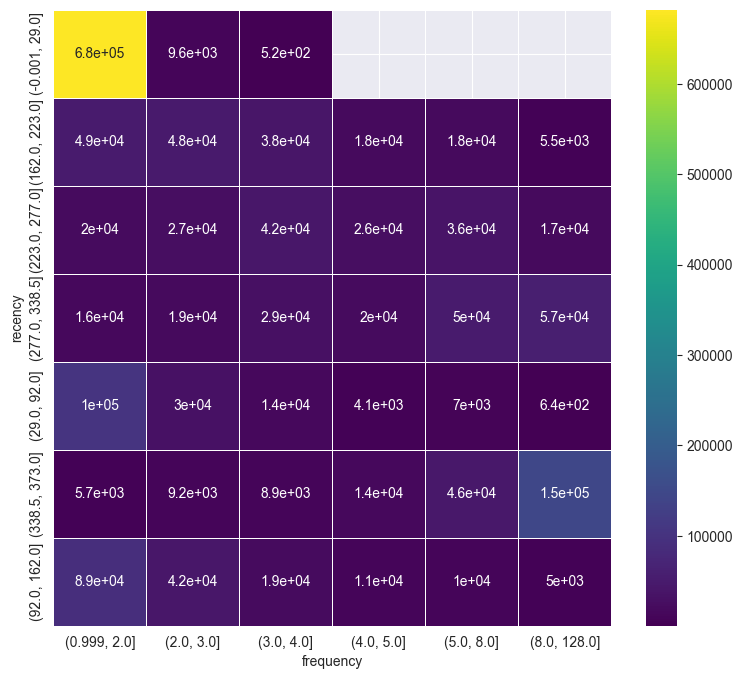

In [7]:
#
# Total monetary value (revenue) by recency-frequency cohorts
#
rfm_q = rfm_df[['customer_id', 'recency', 'frequency', 'monetary_value']].copy()
rfm_q['recency'] = pd.qcut(rfm_df['recency'], 10, duplicates='drop').astype('str')
rfm_q['frequency'] = pd.qcut(rfm_df['frequency'], 10, duplicates='drop').astype('str')

rfm_value_cohorts = rfm_q.groupby(['recency', 'frequency']).sum('monetary_value').reset_index()

rfm_value_cohorts_p = rfm_value_cohorts.pivot(index='recency', columns='frequency', values='monetary_value')
_, ax = plt.subplots(1, 1, figsize=(9, 8))
sns.heatmap(rfm_value_cohorts_p, annot=True, linewidth=.5, cmap="viridis", ax=ax)

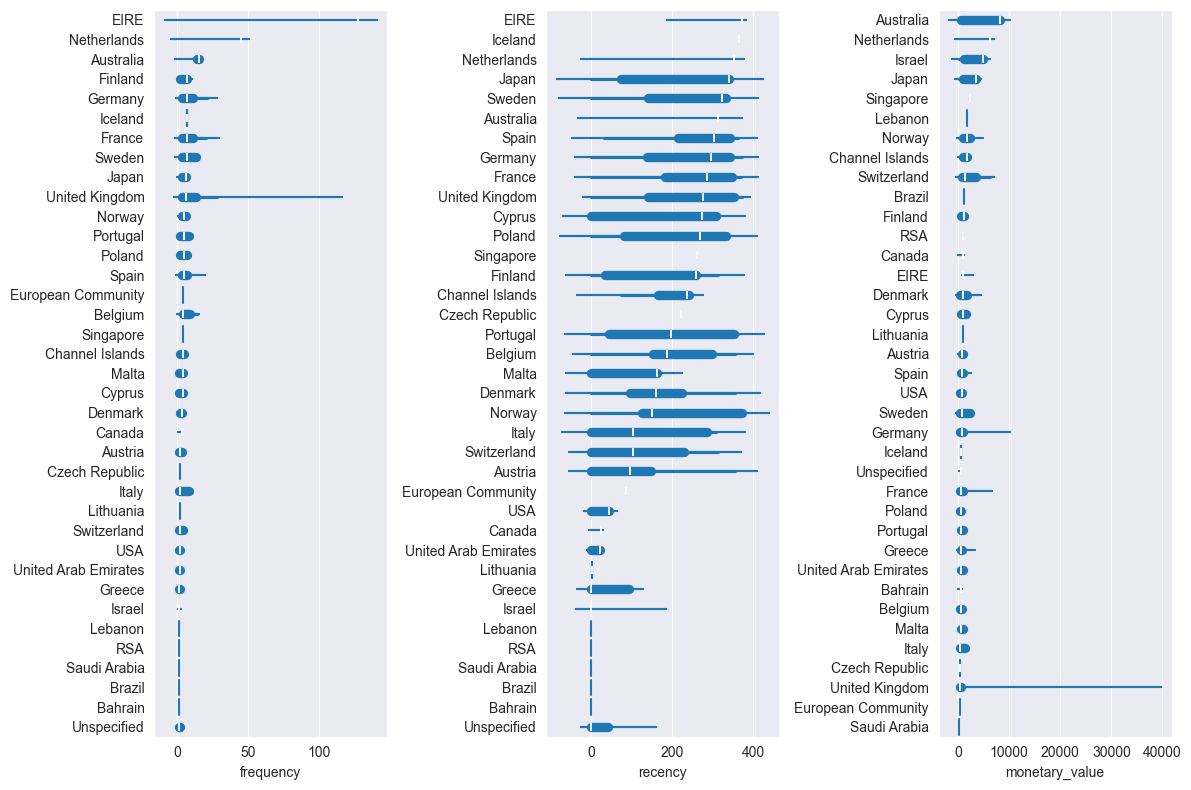

In [8]:
#
# Differences in RFM metrics by country 
#
df = pd.merge(rfm_df, data[['CustomerID', 'Country']], how='inner', left_on='customer_id', right_on='CustomerID')
_, ax = plt.subplots(1, 3, figsize=(3*4, 8))
grouping_dim = 'Country'
for i, metric in enumerate(['frequency', 'recency', 'monetary_value']):
    my_order = df.groupby(by=[grouping_dim])[metric].median().sort_values().iloc[::-1].index
    sns.violinplot(data=df, x=metric, y=grouping_dim, orient='y', inner='box', order=my_order, fill=False, ax=ax[i])
    ax[i].set_ylabel(None)
plt.tight_layout()